In [148]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.cross_validation import KFold


import matplotlib.pyplot as plt


import pandas
import os

%matplotlib inline
%config InlineBackend.figure_formats = {'svg',}
plt.ioff()    # this stops the graphs from overwriting each other

In [149]:
def plot(x, y, regression, labels=[]):
    
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Data')
    ax.scatter(x, y)

    ax.plot(x, regression, label='regression line', lw=2.)
    
    if len(labels) == len(x):
        for ll, x, y in zip(labels, x, y):
            plt.annotate(
                ll,
                fontsize=4,
                xy=(x, y), xytext=(0, 1),
                textcoords='offset points', ha='right', va='bottom')

    plt.legend(loc=0)
    fig.show()
    plt.close(fig)

In [150]:
def regress(method,xtrain,ytrain,xtest,ytest,features):
    
    if method =="linear":
        reg = LinearRegression(fit_intercept = False, normalize = False)
    elif method =="ridge":
        reg = Ridge(alpha = 1, fit_intercept = False, normalize = False)
    elif method =="ridgecv":
        reg = RidgeCV(alphas = [0.0001,0.001,0.01,0.1,1,10,100], fit_intercept = False, normalize = False)
    else:
        print("Invalid method choose from {linear, ridge, ridgecv}")
        return

    reg.fit(xtrain, ytrain)

    y_predict  = reg.predict(xtest)

    mmse = np.mean((y_predict - ytest) ** 2)
    r2  = reg.score(xtest, ytest)
    
    if len(features) == 1:
        plot(xtrain, ytrain, reg.predict(xtrain))
        
    return mmse, r2, reg.coef_

In [151]:
def regress_cv(method,xx,yy,features,n_folds=10,seed=5):
    
    #fix seed for reproducability
    np.random.seed(seed)
    
    if method =="linear":
        reg = LinearRegression(fit_intercept = False, normalize = False)
    elif method =="ridge":
        reg = Ridge(alpha = 1, fit_intercept = False, normalize = False)
    elif method =="ridgecv":
        reg = RidgeCV(alphas = [0.0001,0.001,0.01,0.1,1,10,100], fit_intercept = False, normalize = False)
    else:
        print("Invalid method choose from {linear, ridge, ridgecv}")
        return

    cv_mse    = 0.0
    cv_r2 = 0.0
    
    for ii in range(n_folds):
        
        # split in 90% train and 10%test
        mask =  np.random.rand(len(xx)) < 0.9
        
        this_xtrain = xx[mask]
        this_xtest  = xx[~mask]
        this_ytrain = yy[mask]
        this_ytest  = yy[~mask]

        
        reg.fit(this_xtrain, this_ytrain)

        y_predict  = reg.predict(this_xtest)

        mse = np.mean((y_predict - this_ytest) ** 2)
        r2  = reg.score(this_xtest, this_ytest)
    
        cv_mse += mse
        cv_r2 += r2
        
        if len(features) == 1:
            plot(this_xtrain, this_ytrain, reg.predict(this_xtrain))
    
    
    return cv_mse/float(n_folds), cv_r2/float(n_folds), reg.coef_

In [152]:
corpus = "BrentProvidence"
kk="500"
testontrain= ""# "_test_on_train"

if corpus=="Brent":
    feature_file   = "data/words_sentences/brent_srilm_"+kk+testontrain+".csv"
elif corpus =="Providence":
    feature_file   = "data/words_sentences/providence_srilm_"+kk+testontrain+".csv"
elif corpus == "BrentProvidence":
    feature_file   = "data/words_sentences/brentprovidence_srilm_"+kk+testontrain+".csv"

my_data = pandas.read_csv(feature_file)

my_data = my_data.dropna()
my_data = my_data.reset_index(drop=True)
my_data = my_data

# y will be the same for all feature sets, so we can define it here globally
y       = preprocessing.scale(my_data["y"])

first_numeric_feature = my_data.columns.tolist().index('length')

print(first_numeric_feature)

3


/usr/lib/python3/dist-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


['freq'] 1.03877871327
['freq', 'w1'] 1.00413007893
['freq', 'w1w2'] 1.00023191098
['freq', 'p0w1'] 0.989867371824
['freq', 'p0w1w2'] 1.01005185322
['freq', 'p0p1w1'] 0.992878741849
['freq', 'p0p1w1w2'] 1.01460570036
['freq', 'w1', 'w1w2'] 1.00122669034
['freq', 'p0w1', 'p0w1w2'] 0.992105492462
['freq', 'p0p1w1', 'p0p1w1w2'] 0.994411568891
['freq', 'p0w1', 'p0w1w2', 'p0p1w1', 'p0p1w1w2'] 0.99147535619
['freq', 'w1', 'w1w2', 'p0w1', 'p0w1w2', 'p0p1w1', 'p0p1w1w2'] 0.989886254762


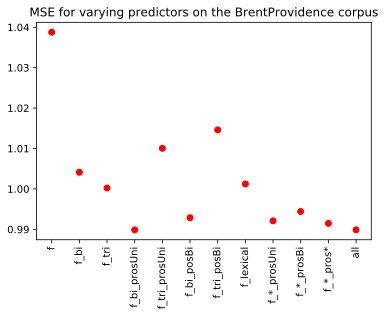

In [153]:
featuresets = [['freq'], ['freq','w1'], ['freq','w1w2'], 
               ['freq','p0w1'], ['freq','p0w1w2'], ['freq','p0p1w1'],
               ['freq','p0p1w1w2'], 
               ['freq','w1','w1w2'],
               ['freq','p0w1','p0w1w2'],
               ['freq','p0p1w1','p0p1w1w2'],
               ['freq','p0w1','p0w1w2','p0p1w1','p0p1w1w2'],
               ['freq','w1','w1w2','p0w1','p0w1w2','p0p1w1','p0p1w1w2']]
modelnames = ['f','f_bi','f_tri',
              'f_bi_prosUni','f_tri_prosUni','f_bi_posBi',
              'f_tri_posBi',
              'f_lexical',
              'f_*_prosUni',
              'f_*_prosBi',
              'f_*_pros*', 
              'all']


method      = "ridge" # options: "linear" ridge" "ridgecv"

mses = []

for features in featuresets:
    
    
    this_x_train       = preprocessing.scale(np.log(my_data[features]))
#    this_x_test        = preprocessing.scale(np.log(my_data[features]))[255:]
    
    
#    mse, r2, coefs = regress(method,this_x_train,y[:255],this_x_test,y[255:],features)
    mse, r2, last_coefs      = regress_cv(method,this_x_train,y,features)    
    
    print(features, mse)
    mses.append(mse)
    
x = list(range(len(mses)))
plt.xticks(x, modelnames, rotation='vertical')
plt.plot(x, mses, 'ro')
plt.title("MSE for varying predictors on the "+corpus+" corpus")
plt.savefig(corpus+kk+testontrain+'_srilm_features.pdf', bbox_inches='tight')
plt.show()


Do the same thing for egemaps features. First load data the compute MSE for different features

In [154]:
corpus = "Brent"

if corpus == "Brent":
    feature_file = "data/words_sentences/brent_avg_prosody_pos.csv"
elif corpus == "Providence":
    feature_file = "data/words_sentences/providence_avg_prosody_pos.csv"
elif corpus == "BrentProvidence":
    feature_file = "data/words_sentences/brentprovidence_avg_prosody_pos.csv"
    
out_file     = open("out/"+corpus+"_egemaps_mse.txt", 'w+')

my_data = pandas.read_csv(feature_file)

my_data = my_data.dropna()
my_data = my_data.reset_index(drop=True)
my_data = my_data

my_data['freq'] = np.log(my_data['freq'])
my_data['length'] = np.log(my_data['length'])

first_numeric_feature = my_data.columns.tolist().index('length')
first_egemaps_feature = my_data.columns.tolist().index('F0semitoneFrom27.5Hz_sma3nz_amean')

# y will be the same for all feature sets, so we can define it here globally
y       = preprocessing.scale(my_data["y"])


[['freq'], ['F0semitoneFrom27.5Hz_sma3nz_amean'], ['F0semitoneFrom27.5Hz_sma3nz_stddevNorm'], ['F0semitoneFrom27.5Hz_sma3nz_percentile20.0'], ['F0semitoneFrom27.5Hz_sma3nz_percentile50.0'], ['F0semitoneFrom27.5Hz_sma3nz_percentile80.0'], ['F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2'], ['F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope'], ['F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope'], ['F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope'], ['F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope'], ['loudness_sma3_amean'], ['loudness_sma3_stddevNorm'], ['loudness_sma3_percentile20.0'], ['loudness_sma3_percentile50.0'], ['loudness_sma3_percentile80.0'], ['loudness_sma3_pctlrange0-2'], ['loudness_sma3_meanRisingSlope'], ['loudness_sma3_stddevRisingSlope'], ['loudness_sma3_meanFallingSlope'], ['loudness_sma3_stddevFallingSlope'], ['spectralFlux_sma3_amean'], ['spectralFlux_sma3_stddevNorm'], ['mfcc1_sma3_amean'], ['mfcc1_sma3_stddevNorm'], ['mfcc2_sma3_amean'], ['mfcc2_sma3_stddevNorm'], ['mfcc3_sma3_amean

/usr/lib/python3/dist-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


['freq']
MSE:  0.897323634134
['F0semitoneFrom27.5Hz_sma3nz_amean']
MSE:  0.925737929417
['F0semitoneFrom27.5Hz_sma3nz_stddevNorm']
MSE:  0.958507133265
['F0semitoneFrom27.5Hz_sma3nz_percentile20.0']
MSE:  0.930118958676
['F0semitoneFrom27.5Hz_sma3nz_percentile50.0']
MSE:  0.933140842328
['F0semitoneFrom27.5Hz_sma3nz_percentile80.0']
MSE:  0.925328929993
['F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2']
MSE:  0.957315308415
['F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope']
MSE:  0.963799349285
['F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope']
MSE:  0.967674889443
['F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope']
MSE:  0.962805480806
['F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope']
MSE:  0.960584854191
['loudness_sma3_amean']
MSE:  0.963802877814
['loudness_sma3_stddevNorm']
MSE:  0.964437511736
['loudness_sma3_percentile20.0']
MSE:  0.964378222579
['loudness_sma3_percentile50.0']
MSE:  0.963337917415
['loudness_sma3_percentile80.0']
MSE:  0.962835464001
['loudness_sma3_pctlrange0-2']
MSE:  0

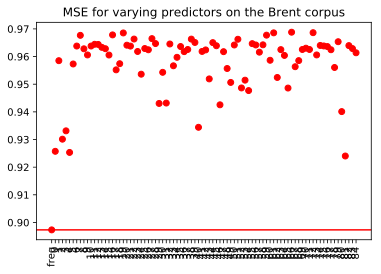

In [155]:
ignore_features = ['hammarbergIndexV_sma3nz_stddevNorm','F3amplitudeLogRelF0_sma3nz_stddevNorm']

featuresets = [['freq']]+[[my_data.columns[ii]] for ii in range(first_egemaps_feature, 93) if my_data.columns[ii] not in ignore_features]
#featuresets = [['freq'], ['freq','length'], ['length'], my_data.columns[first_numeric_feature:]]
#featuresets = [["alphaRatioUV_sma3nz_amean"], ["alphaRatioV_sma3nz_amean"], ["F0semitoneFrom27.5Hz_sma3nz_amean"], ["F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2"], ["F0semitoneFrom27.5Hz_sma3nz_percentile20.0"], ["F0semitoneFrom27.5Hz_sma3nz_percentile50.0"], ["F0semitoneFrom27.5Hz_sma3nz_percentile80.0"], ["F1bandwidth_sma3nz_stddevNorm"], ["F1frequency_sma3nz_amean"], ["F2bandwidth_sma3nz_stddevNorm"], ["F2frequency_sma3nz_amean"], ["F3bandwidth_sma3nz_amean"], ["F3bandwidth_sma3nz_stddevNorm"], ["F3frequency_sma3nz_amean"], ["F3frequency_sma3nz_stddevNorm"], ["hammarbergIndexUV_sma3nz_amean"], ["hammarbergIndexV_sma3nz_stddevNorm"], ["HNRdBACF_sma3nz_amean"], ["jitterLocal_sma3nz_amean"], ["jitterLocal_sma3nz_stddevNorm"], ["loudnessPeaksPerSec"], ["loudness_sma3_pctlrange0-2"], ["loudness_sma3_stddevRisingSlope"], ["MeanVoicedSegmentLengthSec"], ["mfcc2_sma3_amean"], ["mfcc2V_sma3nz_amean"], ["mfcc3_sma3_amean"], ["mfcc3V_sma3nz_amean"], ["mfcc4_sma3_amean"], ["mfcc4_sma3_stddevNorm"], ["mfcc4V_sma3nz_amean"], ["shimmerLocaldB_sma3nz_stddevNorm"], ["slopeV500-1500_sma3nz_amean"], ["spectralFlux_sma3_amean"], ["spectralFluxV_sma3nz_stddevNorm"], ["VoicedSegmentsPerSec"]]
#featuresets = [["freq"], ["F1frequency_sma3nz_amean"], ["F0semitoneFrom27.5Hz_sma3nz_percentile50.0"], ["F0semitoneFrom27.5Hz_sma3nz_percentile20.0"], ["F0semitoneFrom27.5Hz_sma3nz_amean"], ["F0semitoneFrom27.5Hz_sma3nz_percentile80.0"], ["MeanVoicedSegmentLengthSec"],["F1frequency_sma3nz_amean", "F0semitoneFrom27.5Hz_sma3nz_percentile50.0", "F0semitoneFrom27.5Hz_sma3nz_percentile20.0", "F0semitoneFrom27.5Hz_sma3nz_amean", "F0semitoneFrom27.5Hz_sma3nz_percentile80.0", "MeanVoicedSegmentLengthSec"]]
#featuresets = [["freq"], ["freq","F1frequency_sma3nz_amean"], ["freq","F0semitoneFrom27.5Hz_sma3nz_percentile50.0"], ["freq","F0semitoneFrom27.5Hz_sma3nz_percentile20.0"], ["freq","F0semitoneFrom27.5Hz_sma3nz_amean"], ["freq","F0semitoneFrom27.5Hz_sma3nz_percentile80.0"], ["freq","MeanVoicedSegmentLengthSec"],["freq","F1frequency_sma3nz_amean", "F0semitoneFrom27.5Hz_sma3nz_percentile50.0", "F0semitoneFrom27.5Hz_sma3nz_percentile20.0", "F0semitoneFrom27.5Hz_sma3nz_amean", "F0semitoneFrom27.5Hz_sma3nz_percentile80.0", "MeanVoicedSegmentLengthSec"]]
method      = "ridgecv" # options: "linear" ridge" "ridgecv"

#modelnames = ["f", "f_p1", "f_p2", "f_p3", "f_p4", "f_p5", "f_p6", "f_all"]
modelnames = ['freq']+[str(i) for i in range(len(featuresets)-1)]

mses = []

print(featuresets)

for features in featuresets:
    
    this_x_train = my_data[features]

    # DON'T Log features here since I'm not sure they're skewed and they're certainly not strictly positive
    # take log of features (defining log(0)=0)
    # this_x_train = np.where(this_x_train != 0, np.log(this_x_train), 0)
    
    # scale features
    this_x_train = preprocessing.scale(this_x_train)
    
 
    #this_x_test        = preprocessing.scale(np.log(my_data[features]))[255:]
    #mse, r2, coefs = regress(method,this_x_train,y[:255],this_x_test,y[255:],features)
    

    mse, r2, last_coefs      = regress_cv(method,this_x_train,y,features)    
    
    
    print(features)
    print("MSE: ", mse)
    
    out_file.write(",".join([" ".join(features), str(mse)])+"\n")
    
    mses.append(mse)
    
#    print("coefficients")
#    for i, value in enumerate(last_coefs):
#        print(features[i], value)
    
    
out_file.close()
    
    
x = list(range(len(mses)))
plt.xticks(x, modelnames, rotation='vertical')
plt.plot(x, mses, 'ro')
plt.axhline(y=mses[0], color='r', linestyle='-')
plt.title("MSE for varying predictors on the "+corpus+" corpus")
plt.savefig(corpus+'_egemaps_features_all.pdf', bbox_inches='tight')
plt.show()